# **Phase 2 - Milestone 2**

**Ediashta Revindra Amirussalam**
<br>FTDS-020-RMT

## Objective

## 00 - Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
import glob
import random
import cv2

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPool2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
tf.__version__

'2.12.0'

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 01 - Data Loading

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm ~/.kaggle

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
!mkdir ~/.kaggle

!cp '/content/drive/MyDrive/kaggle/kaggle.json' ~/.kaggle

In [ ]:
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d ananthu017/emotion-detection-fer

 98% 64.0M/65.2M [00:02<00:00, 36.2MB/s]
100% 65.2M/65.2M [00:02<00:00, 29.2MB/s]


In [ ]:
!unzip -q /content/emotion-detection-fer.zip -d images

In [ ]:
main_path = ('/content/images')
os.listdir(main_path)

['test', 'train']

In [ ]:
train_dir = os.path.join(main_path, 'train')
test_dir = os.path.join(main_path, 'test')
os.listdir(train_dir)

['sad', 'angry', 'disgusted', 'happy', 'neutral', 'surprised', 'fearful']

In [ ]:
def check_dir(dir=None, labels=None):
  i=0
  for label in labels:
    num_data= len(os.listdir(os.path.join(dir, label)))
    print(f'Data', label, ' :', num_data)
    i+= num_data
  print('Total Data :', i)



In [ ]:
print('train set: \n' + '='*50)
check_dir(train_dir,os.listdir(train_dir))
print('\ntest set: \n' + '='*50)
check_dir(test_dir,os.listdir(test_dir))

train set: 
Data sad  : 4830
Data angry  : 3995
Data disgusted  : 436
Data happy  : 7215
Data neutral  : 4965
Data surprised  : 3171
Data fearful  : 4097
Total Data : 28709

test set: 
Data sad  : 1247
Data angry  : 958
Data disgusted  : 111
Data happy  : 1774
Data neutral  : 1233
Data surprised  : 831
Data fearful  : 1024
Total Data : 7178


## 02 - EDA & Preprocessing

### Display Sample Image

(48, 48)


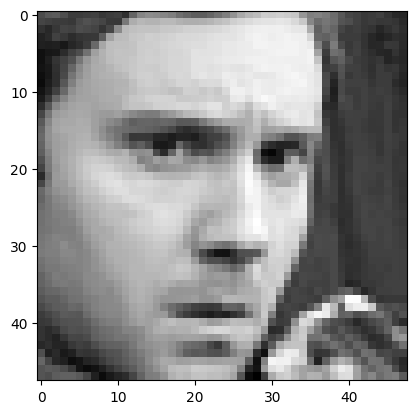

In [ ]:
img = plt.imread(f'{train_dir}/angry/im0.png')
print(img.shape)
plt.imshow(img, cmap="gray")

#### Image Distribution

In [ ]:
class_labels  = [class_name.capitalize() for class_name in os.listdir(train_dir)]
img_height = 48
img_width = 48
batch_size = 64

In [ ]:
img_count = pd.DataFrame(columns=['label', 'count'])

for i in os.listdir(train_dir):
    value = len([fn for fn in os.listdir(f'{train_dir}/{i}/') if fn.endswith('.png')])
    img_count.loc[len(img_count.index)] = [i, value]

img_count.sort_values(by="count", ascending=False, inplace=True)

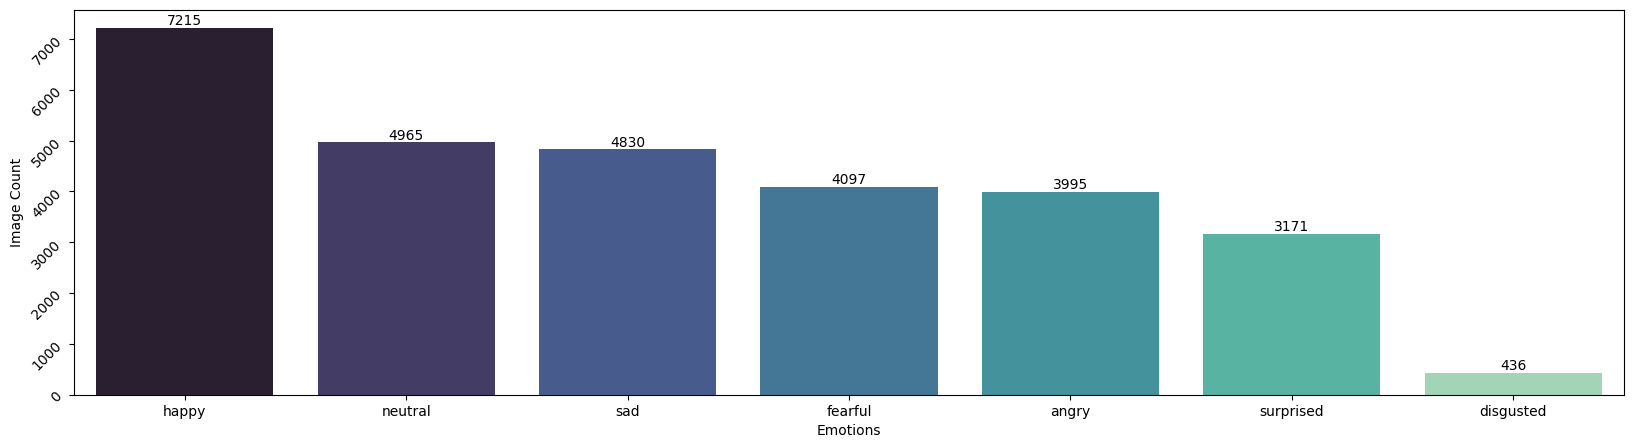

In [ ]:
plt.figure(figsize=(20,5))
fig = sns.barplot(x="label",
                  y="count",
                  data=img_count,
                  palette="mako")
fig.set(xlabel="Emotions", ylabel="Image Count")

for i in fig.containers:
    fig.bar_label(i,)

plt.yticks(rotation=45)
plt.show()

### Individual Emotion Analysis

In [ ]:
def visualize_img(title, train_dir):
    random.seed(5)
    images = random.sample([fn for fn in os.listdir(f'{train_dir}/{title}') if fn.endswith('.png')],7)
    fig, axes = plt.subplots(1,7, figsize=(21,5))

    for i, x in enumerate(images):
        img = plt.imread(f'{train_dir}/{title}/{x}')
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(title.capitalize())
        axes[i].axis('off')

    fig.tight_layout()

#### Angry

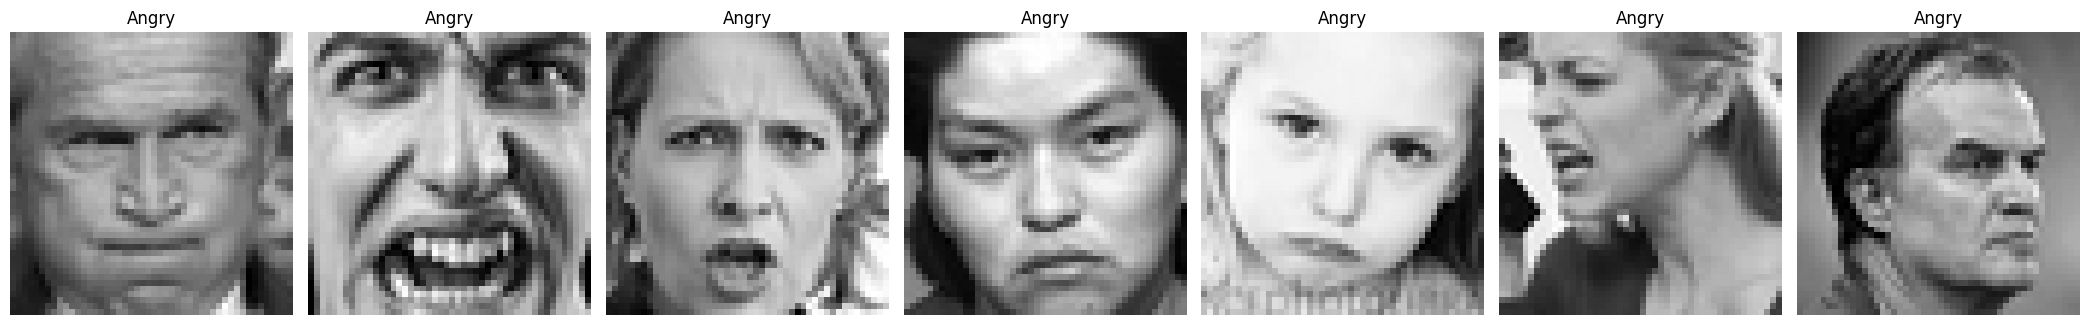

In [ ]:
visualize_img('angry', train_dir)

#### Disgusted

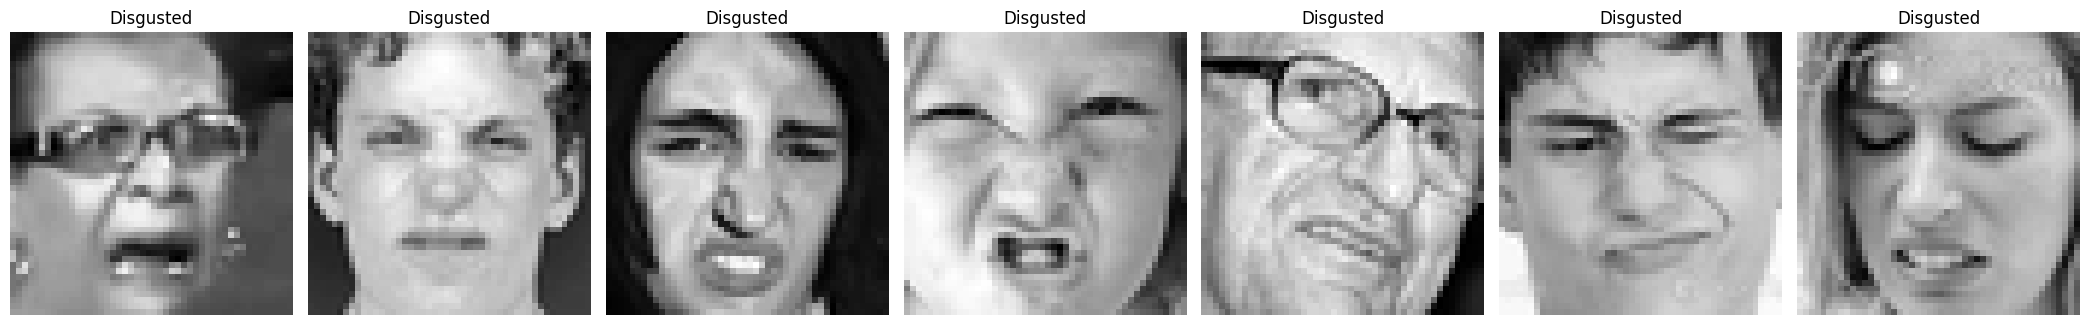

In [ ]:
visualize_img('disgusted', train_dir)

#### Fearful

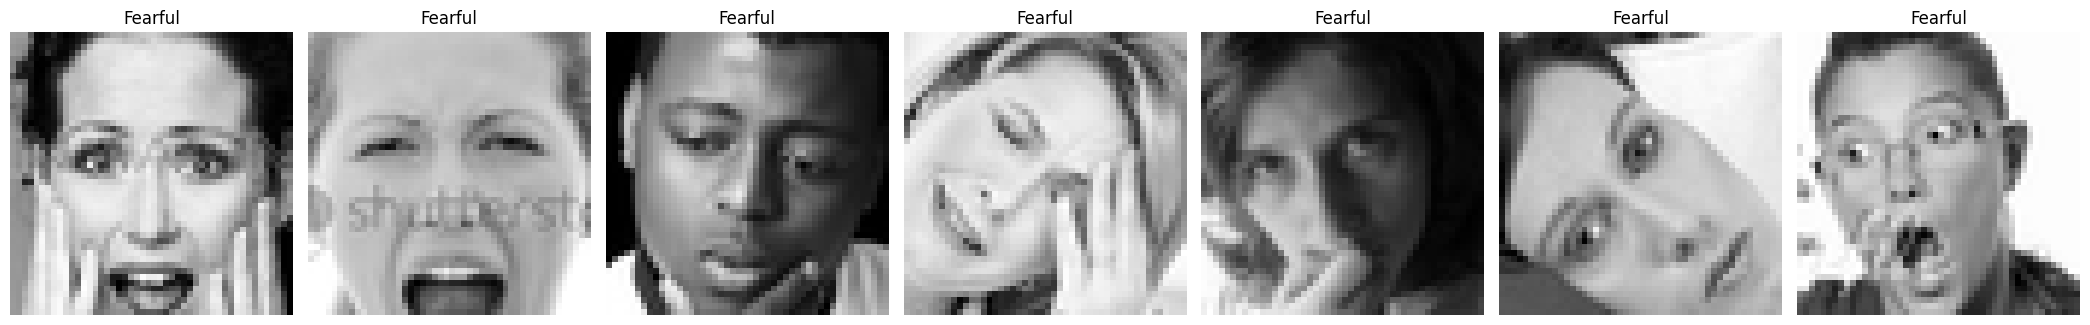

In [ ]:
visualize_img('fearful', train_dir)

#### Happy

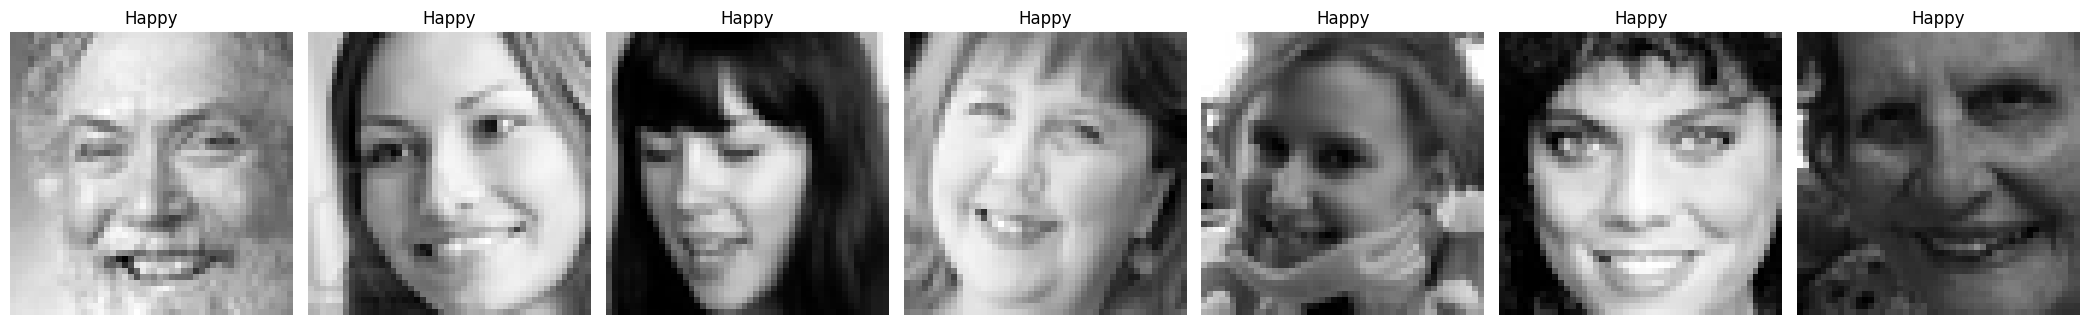

In [ ]:
visualize_img('happy', train_dir)

#### Neutral

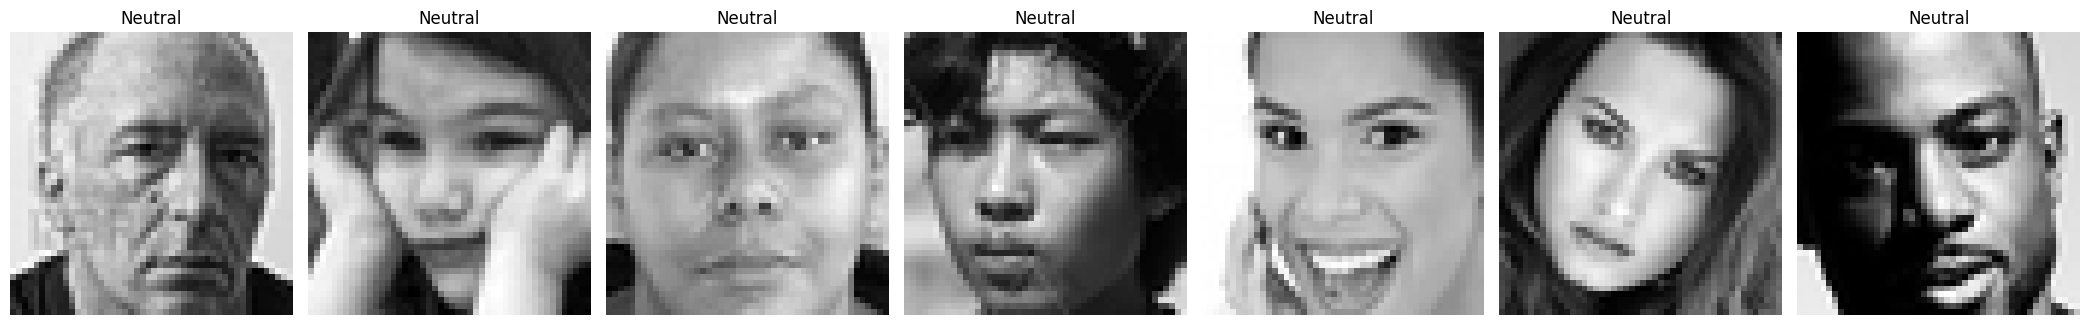

In [ ]:
visualize_img('neutral', train_dir)

#### Sad

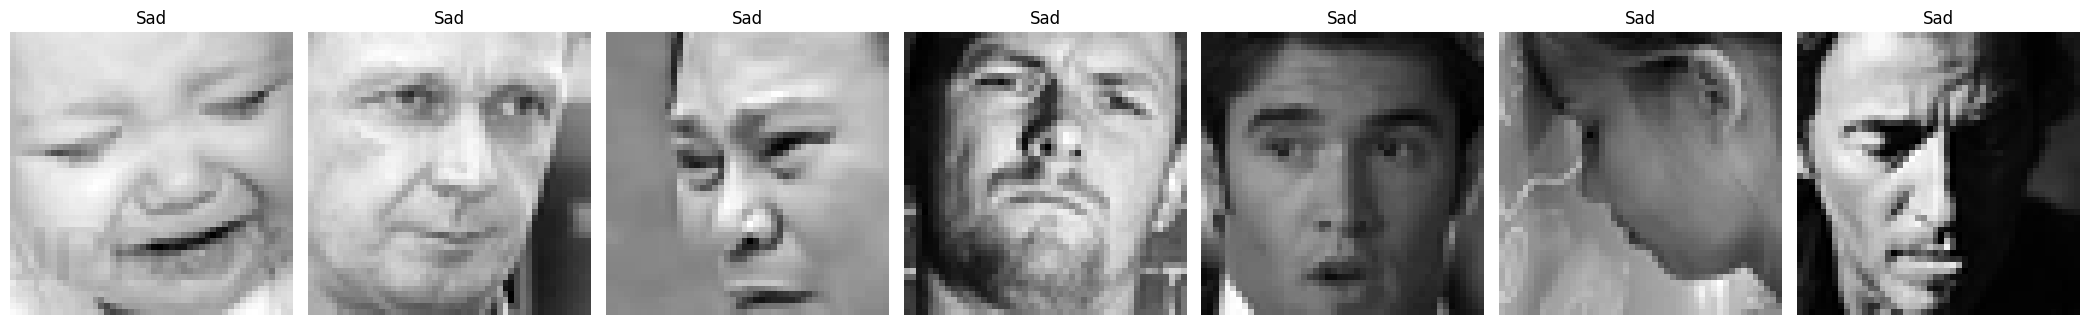

In [ ]:
visualize_img('sad', train_dir)

#### Surprised

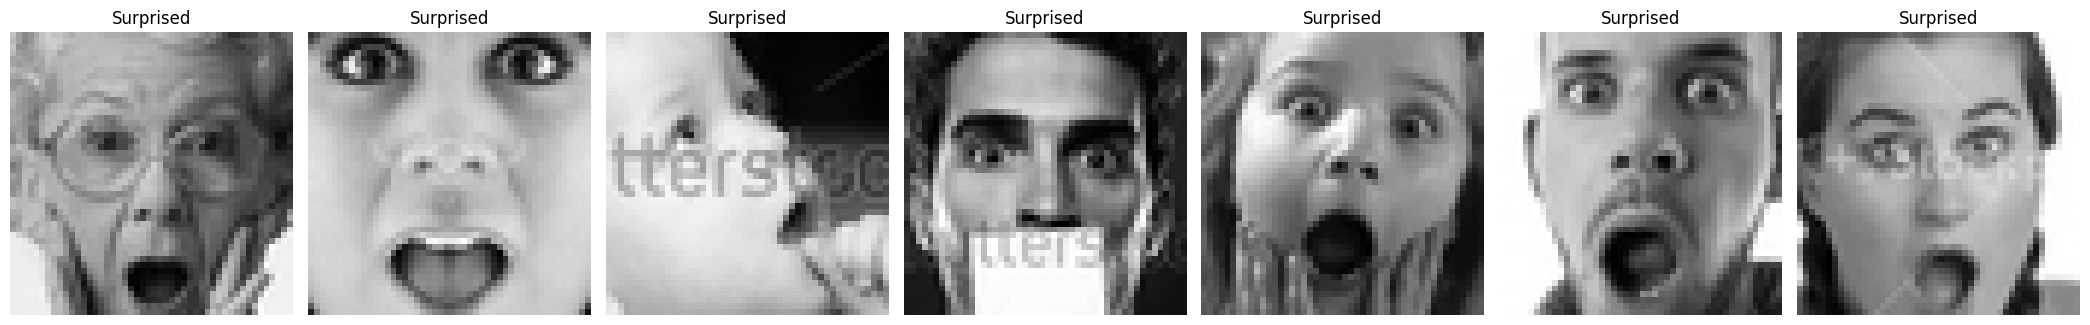

In [ ]:
visualize_img('surprised', train_dir)

### Image Vector Mean

In [ ]:
def img2np(path, list_of_filename, size = (48, 48)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size,
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError:
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

In [ ]:
def find_mean_img(full_mat, title, axes, loc, size = (48, 48)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)

    # mean_img = sharpened

    axes[loc].imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    axes[loc].set_title(f'Average {title}')
    return mean_img

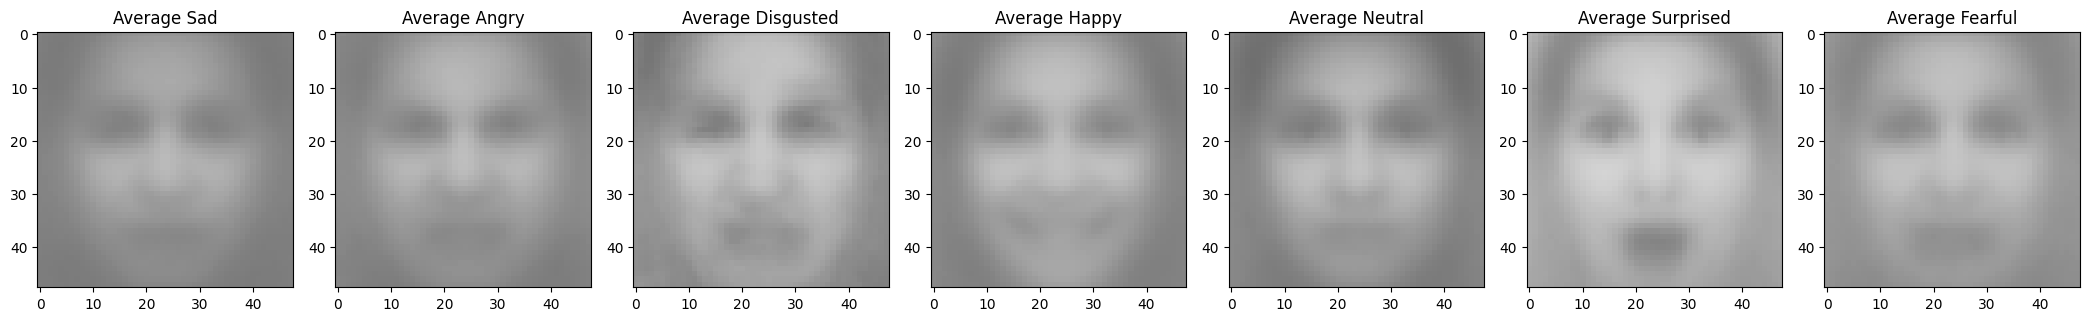

In [ ]:
fig, axes= plt.subplots(1,7, figsize=(21,3))
count = 0

for i in os.listdir(train_dir):
    images = [fn for fn in os.listdir(f'{train_dir}/{i}') if fn.endswith('.png')]
    vector = img2np(f'{train_dir}/{i}/',images)
    find_mean_img(vector, i.capitalize(),axes, count)

    count+=1

plt.tight_layout()
plt.show()

### Preprocessing and Augmentation

In [ ]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_ds = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_height ,img_width),
                                                    batch_size = batch_size,
                                                    shuffle  = True ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

val_ds = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (img_height ,img_width),
                                                         batch_size = batch_size,
                                                         shuffle  = True ,
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_ds = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (img_height ,img_width),
                                                    batch_size = batch_size,
                                                    shuffle  = False ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
for image_batch , label_batch in train_ds:
  print(image_batch.shape)
  print(label_batch.shape)
  break

(64, 48, 48, 3)
(64, 7)


## 03 - Base Model

### Model Definition

In [ ]:
# clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Define the input shape and number of classes for your dataset
input_shape = (img_height, img_width, 3)
num_classes = 7

In [ ]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

### Model Training

In [ ]:
history = model.fit(x = train_ds,
                    epochs = 30,
                    validation_data = val_ds)

Epoch 1/30
359/359 [==============================] - 76s 163ms/step - loss: 9.2763 - accuracy: 0.1958 - val_loss: 9.5459 - val_accuracy: 0.1730
Epoch 2/30
359/359 [==============================] - 48s 132ms/step - loss: 8.2276 - accuracy: 0.2359 - val_loss: 7.7295 - val_accuracy: 0.2465
Epoch 3/30
359/359 [==============================] - 47s 132ms/step - loss: 7.2030 - accuracy: 0.2584 - val_loss: 6.5482 - val_accuracy: 0.2966
Epoch 4/30
359/359 [==============================] - 45s 124ms/step - loss: 6.2343 - accuracy: 0.2792 - val_loss: 5.5854 - val_accuracy: 0.3381
Epoch 5/30
359/359 [==============================] - 47s 130ms/step - loss: 5.3360 - accuracy: 0.3077 - val_loss: 4.8718 - val_accuracy: 0.3322
Epoch 6/30
359/359 [==============================] - 47s 132ms/step - loss: 4.5923 - accuracy: 0.3273 - val_loss: 4.1271 - val_accuracy: 0.3766
Epoch 7/30
359/359 [==============================] - 48s 133ms/step - loss: 3.9657 - accuracy: 0.3530 - val_loss: 3.6805 - val_ac

In [ ]:
history_df = pd.DataFrame(history.history)

history_df.tail()

,loss,accuracy,val_loss,val_accuracy
25,1.471821,0.590343,1.453056,0.600941
26,1.458837,0.594871,1.460521,0.594844
27,1.449142,0.599443,1.463585,0.596063
28,1.433505,0.604929,1.481004,0.589967
29,1.432476,0.604493,1.648776,0.560704


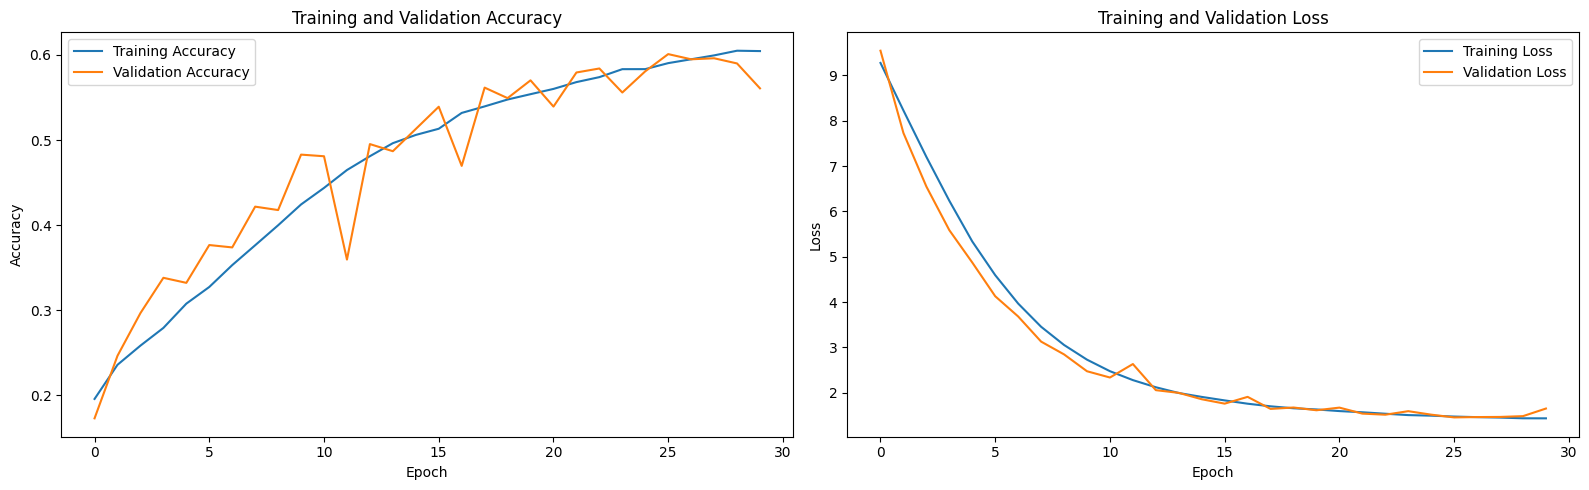

In [ ]:
plt.figure(figsize=(16, 5))

# First subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history_df["accuracy"], label="Training Accuracy")
plt.plot(history_df["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Second subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history_df["loss"], label="Training Loss")
plt.plot(history_df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
model.trainable = False
model.save("/content/drive/MyDrive/FTDS/Emotion Classification/model_default.h5")

### Model Evaluation

In [ ]:
model.evaluate(test_ds)
preds = model.predict(test_ds)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_ds.labels)

113/113 [==============================] - 5s 40ms/step


In [ ]:
cm_array = confusion_matrix(y_true=y_test, y_pred=y_preds)

In [ ]:
cm_array

array([[ 463,   21,  119,   39,  158,  136,   22],
       [  22,   61,    7,    4,    9,    8,    0],
       [  67,    7,  513,   35,  148,  166,   88],
       [  21,    0,   46, 1515,  115,   45,   32],
       [  35,    4,   78,   65,  902,  139,   10],
       [  85,    5,  180,   55,  273,  634,   15],
       [  13,    1,  100,   31,   23,   22,  641]])

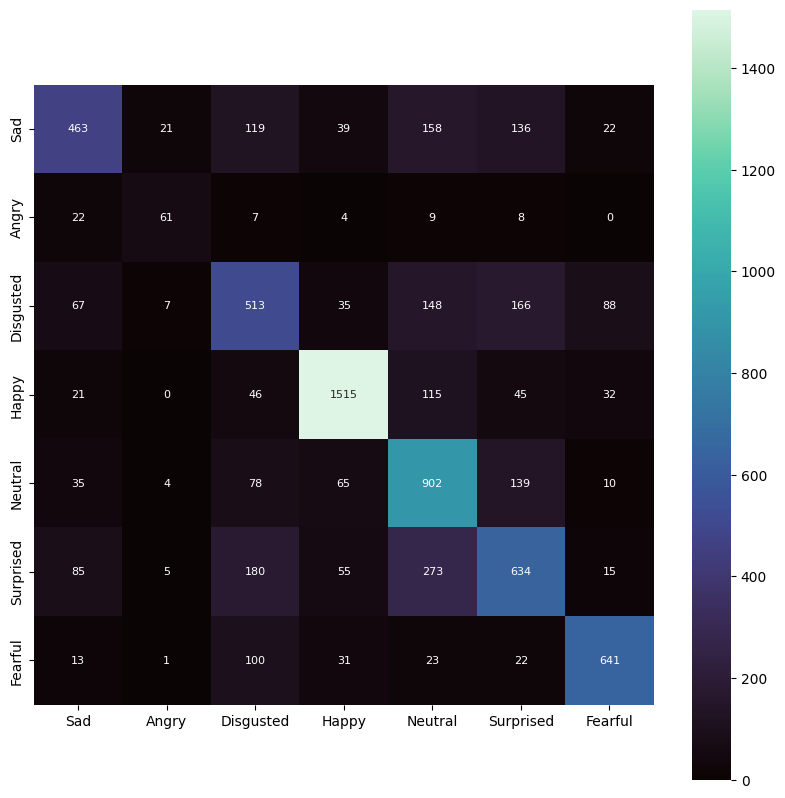

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(cm_array, cmap="mako",
                 annot=True, square=True,
                 annot_kws={"size": 8}, fmt='g',
                 xticklabels=class_labels, yticklabels=class_labels)


## 04 - Fine Tuned Model

### Model Definition

In [ ]:
# clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
def final_model(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=input_shape,
                                               include_top=False,
                                               weights="imagenet")(inputs)

    x = tf.keras.layers.GlobalAveragePooling2D()(feature_extractor)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(num_classes, activation="softmax", name="classification")(x)
    return x

def define_compile_model():

    inputs = tf.keras.layers.Input(shape=input_shape)
    classification_output = final_model(inputs)

    model = tf.keras.Model(inputs=inputs, outputs = classification_output)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

    return model

In [ ]:
model_ft = define_compile_model()

# Feezing the feature extraction layers
model_ft.layers[1].trainable = False

model_ft.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               426240    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                             

### Model Training

In [ ]:
modelCheckpointCallback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/FTDS/Emotion Classification',
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True,
)

earlyStoppingCallback = EarlyStopping(monitor='accuracy',
                                      patience=5,
                                      verbose= 1 ,
                                      restore_best_weights=True
                                      )

In [ ]:
history_ft = model_ft.fit(x = train_ds,
                    epochs = 40 ,
                    validation_data = val_ds ,
                    callbacks= [earlyStoppingCallback,
                                modelCheckpointCallback])

Epoch 1/40
359/359 [==============================] - 192s 222ms/step - loss: 12.5028 - accuracy: 0.2503 - val_loss: 10.1441 - val_accuracy: 0.1683
Epoch 2/40
359/359 [==============================] - 72s 201ms/step - loss: 6.5728 - accuracy: 0.4360 - val_loss: 5.2107 - val_accuracy: 0.3397
Epoch 3/40
359/359 [==============================] - 73s 202ms/step - loss: 3.9369 - accuracy: 0.5202 - val_loss: 3.1233 - val_accuracy: 0.5537
Epoch 4/40
359/359 [==============================] - 73s 204ms/step - loss: 2.6172 - accuracy: 0.5701 - val_loss: 2.1949 - val_accuracy: 0.5797
Epoch 5/40
359/359 [==============================] - 72s 199ms/step - loss: 1.9148 - accuracy: 0.6053 - val_loss: 1.7334 - val_accuracy: 0.5955
Epoch 6/40
359/359 [==============================] - 72s 201ms/step - loss: 1.5142 - accuracy: 0.6355 - val_loss: 1.4337 - val_accuracy: 0.6079
Epoch 7/40
359/359 [==============================] - 75s 210ms/step - loss: 1.2796 - accuracy: 0.6509 - val_loss: 1.2911 - val

In [ ]:
history_ft_df = pd.DataFrame(history_ft.history)

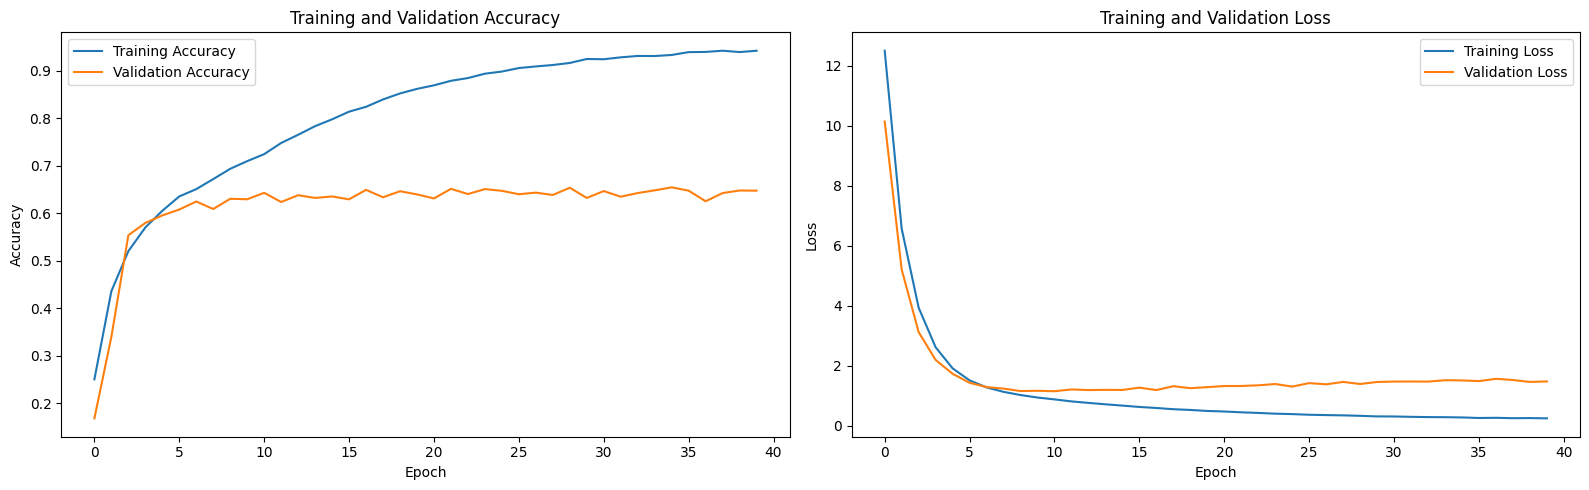

In [ ]:
plt.figure(figsize=(16, 5))

# First subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history_ft_df["accuracy"], label="Training Accuracy")
plt.plot(history_ft_df["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Second subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history_ft_df["loss"], label="Training Loss")
plt.plot(history_ft_df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
model_ft.trainable = False
model_ft.save("/content/drive/MyDrive/FTDS/Emotion Classification/model_fine_tune.h5")

### Model Evaluation

In [ ]:
model_ft.evaluate(test_ds)
preds_ft = model_ft.predict(test_ds)
y_preds_ft = np.argmax(preds_ft , axis = 1 )
y_test_ft = np.array(test_ds.labels)

113/113 [==============================] - 9s 58ms/step


In [ ]:
cm_array_ft = confusion_matrix(y_true=y_test_ft, y_pred=y_preds_ft)

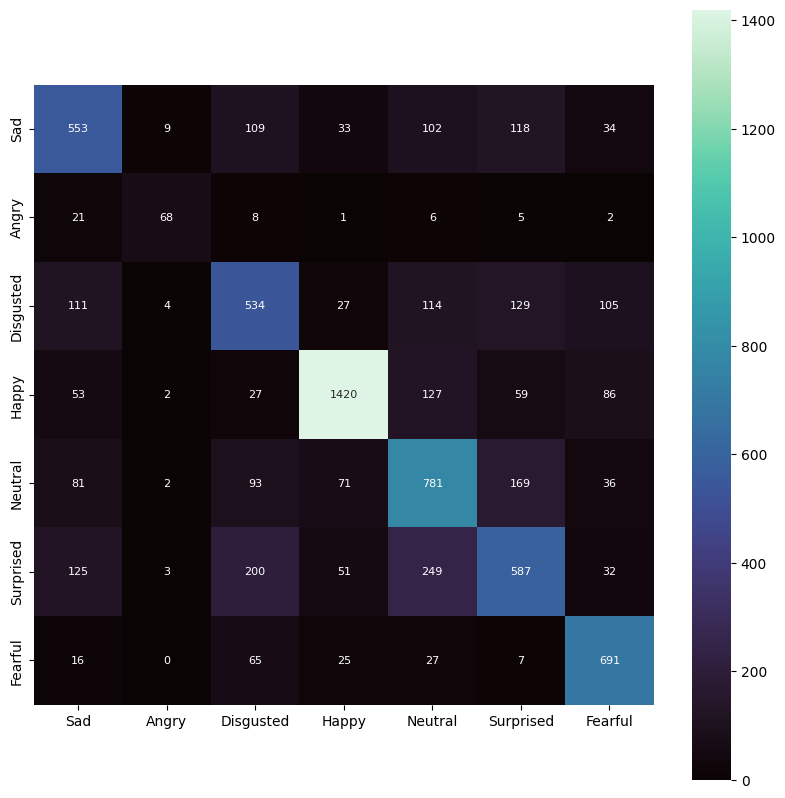

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(cm_array_ft, cmap="mako",
                 annot=True, square=True,
                 annot_kws={"size": 8}, fmt='g',
                 xticklabels=class_labels, yticklabels=class_labels)
